In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd

df = pd.read_csv("/content/upi_transactions_2024.csv")

print(df['fraud_flag'].value_counts())
print(df['fraud_flag'].value_counts(normalize=True)*100)

fraud_flag
0.0    114085
1.0       220
Name: count, dtype: int64
fraud_flag
0.0    99.807532
1.0     0.192468
Name: proportion, dtype: float64


In [ ]:
df = df.drop(['transaction id', 'timestamp'], axis=1)

In [ ]:
X = df.drop('fraud_flag', axis=1)
y = df['fraud_flag']

In [ ]:
#Some columns are categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Method 1

In [ ]:
1.1"""from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
import pandas as pd

# Identify rows where 'fraud_flag' (y) is NaN
nan_rows = y.isna()

# Drop these rows from both X and y
X_cleaned = X[~nan_rows]
y_cleaned = y[~nan_rows]

# Split the data into training and testing sets using the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)

smote_tomek = SMOTETomek(random_state=42)

X_train_encoded = preprocessor.fit_transform(X_train)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_encoded, y_train)

print(pd.Series(y_resampled).value_counts())"""

"from imblearn.combine import SMOTETomek\nfrom sklearn.model_selection import train_test_split\nimport pandas as pd\n\n# Identify rows where 'fraud_flag' (y) is NaN\nnan_rows = y.isna()\n\n# Drop these rows from both X and y\nX_cleaned = X[~nan_rows]\ny_cleaned = y[~nan_rows]\n\n# Split the data into training and testing sets using the cleaned data\nX_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)\n\nsmote_tomek = SMOTETomek(random_state=42)\n\nX_train_encoded = preprocessor.fit_transform(X_train)\nX_resampled, y_resampled = smote_tomek.fit_resample(X_train_encoded, y_train)\n\nprint(pd.Series(y_resampled).value_counts())"

1.2

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_encoded, y_train
)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_resampled).value_counts())

Before SMOTE:
 fraud_flag
0.0    91268
1.0      176
Name: count, dtype: int64
After SMOTE:
 fraud_flag
0.0    91268
1.0    91268
Name: count, dtype: int64


In [ ]:
#Can use Any algorithm
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

X_test_encoded = preprocessor.transform(X_test)

y_pred = model.predict(X_test_encoded)
y_prob = model.predict_proba(X_test_encoded)[:,1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     22817
         1.0       0.00      0.00      0.00        44

    accuracy                           1.00     22861
   macro avg       0.50      0.50      0.50     22861
weighted avg       1.00      1.00      1.00     22861

Confusion Matrix:

[[22817     0]
 [   44     0]]
ROC-AUC: 0.5495971902927244
PR-AUC: 0.002201988757810029


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


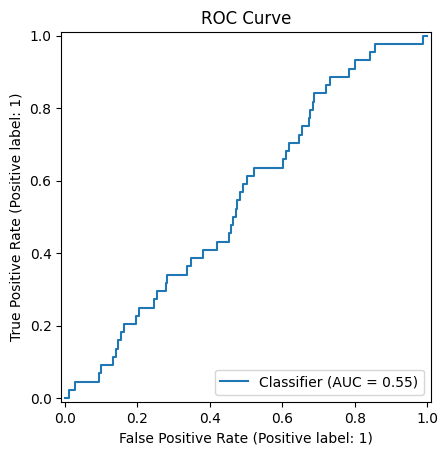

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.show()

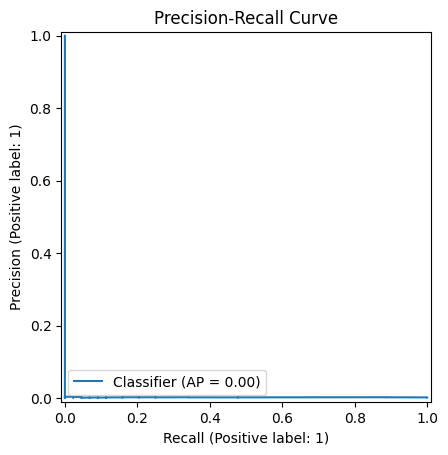

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision-Recall Curve")
plt.show()

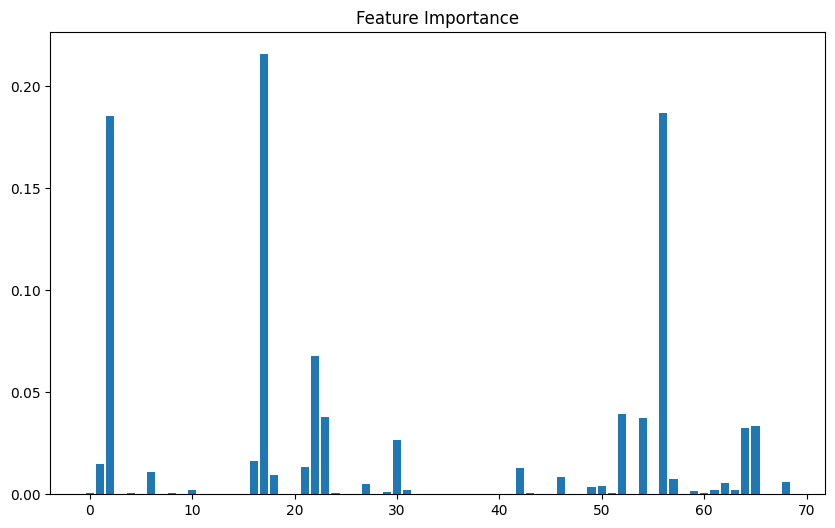

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(range(len(model.feature_importances_)),
        model.feature_importances_)
plt.title("Feature Importance")
plt.show()

Method2

In [ ]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [ ]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

X_test_encoded = preprocessor.transform(X_test)

y_pred = model.predict(X_test_encoded)
y_prob = model.predict_proba(X_test_encoded)[:,1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     22817
         1.0       0.00      0.02      0.01        44

    accuracy                           0.98     22861
   macro avg       0.50      0.50      0.50     22861
weighted avg       1.00      0.98      0.99     22861

Confusion Matrix:

[[22513   304]
 [   43     1]]
ROC-AUC: 0.49068178829979237
PR-AUC: 0.002139728052593802
